# Report Bacteria tracking 
experiment: 27.10.2020


## Summary
* TrackMate detected 24500 trajectories across the full data set. For each replica more than 500 trajectories was detected, most of the trajectories proceed longer than 7 time frames (from total 12)

* We estimated flow in the chamber as a result of  single cells displacements analysis. We have found that  PSA_KB_M9Succ 1 and 2 replicas express high flow . Therefore, PSA_KB_M9Succ 1 and 2 replicas were excluded from the further analysis.

* For each trajectories we calculated and analyzed set of the measurement.Interestigly, the turning angle distributions show that bacteria prefer do not change directions. Also,the distributions of angles between movement directions and image X-axis indicate preferred moving directions and indicate flow in the chamber.

* We performed PCA on trajectories measurements data and observed two cluster and identified them using Gassian Mixture Model. We called them as they appear in PCA plot: compact and diffuse.

* The observed clusters express different proportions in data set. For each experiment analyzed separately the fraction of trajectories belong to the compact cluster was between 60% and 90%, while the diffuse cluster was responsible only for 10% - 40% of trajectories.

* The compact cluster is composed of relatively slow cells which makes larger turns, while in the diffuse cluster, cells move faster and take less turns.

* Also, diffuse trajectories have less time frame length than compact ones.This effect can be caused by the fast and directed movement of the cells from the diffuse cluster - within the period of record, these cells can come and leave the focal plane, so their trajectories cannot be recorded in the full length.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.exposure import equalize_hist

import glob
import os
import multiprocess

from skimage import exposure
import seaborn as sns

### Physical units
dx=0.355 #px/micron
dxx=1/0.355 #micron/px
dt=1.242 #s

import data_viz

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

## TrackMate tracking results

For tracking bacteria movement we used TrackMate plugin available in FiJI. TrackMate requires to set linking distance parameter. Linking distance is the maximum range that bacteria can move between consecutive frames to be linked in one trajectories, therefore, sets limit to trajectory maximum speed. We set the maximum linking distance equal to 15 microns.

TrackMate detected 24500 trajectories with a trajectories length greater than 3 frames. The overlay of all detected trajectories are presented below.

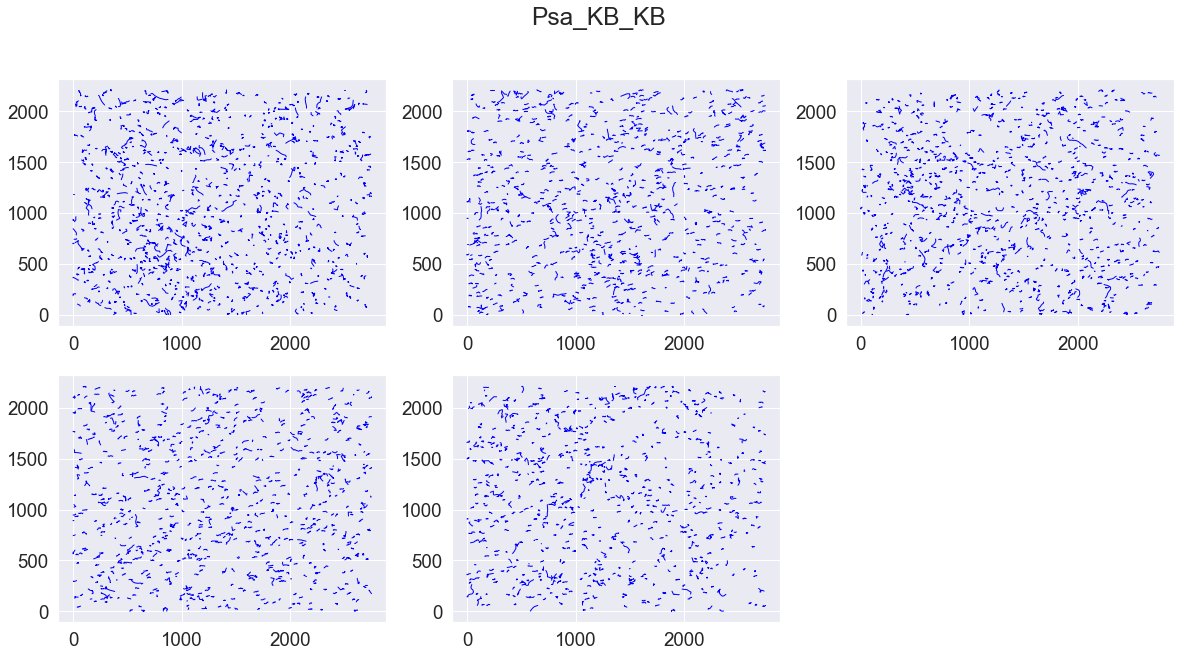

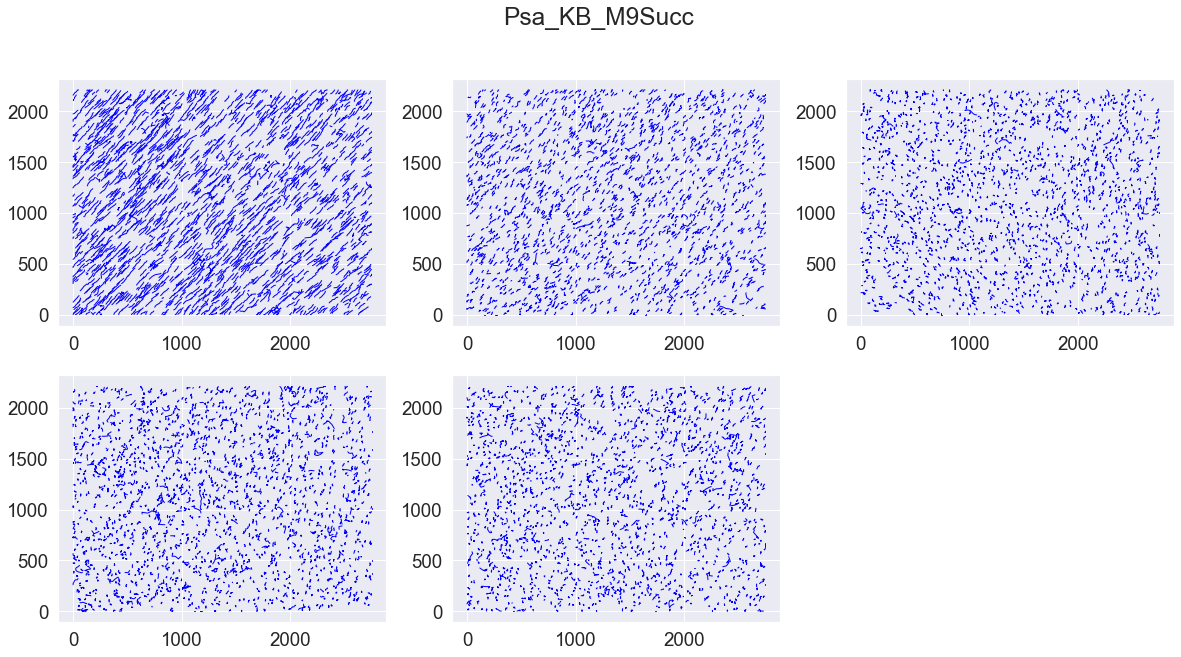

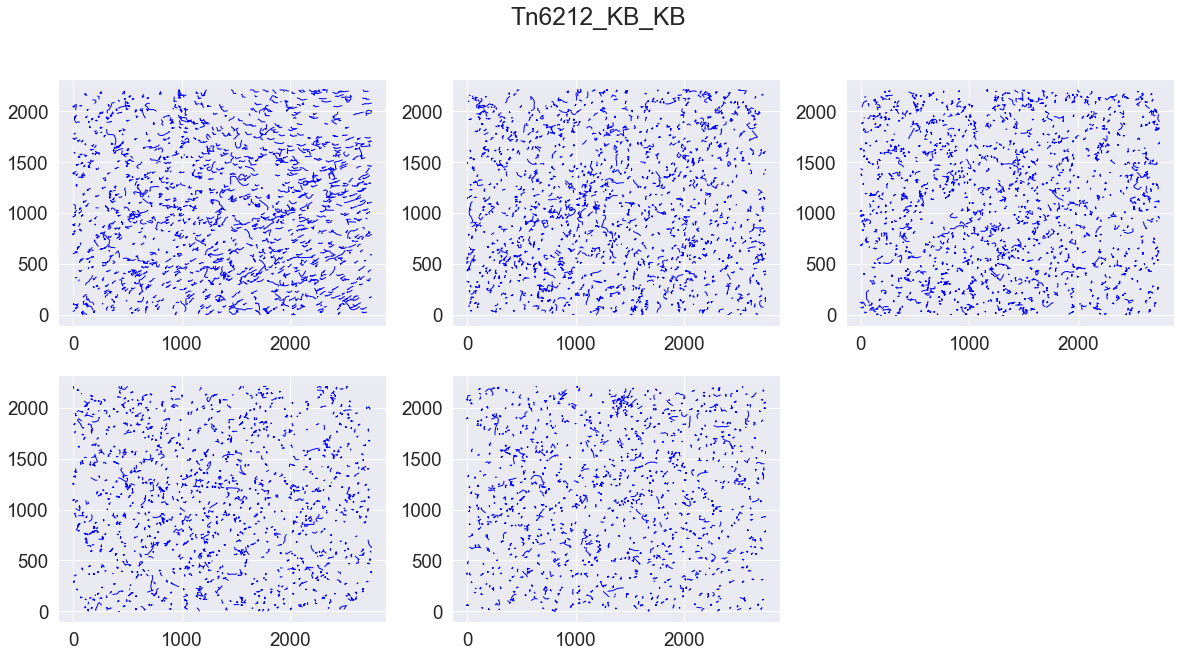

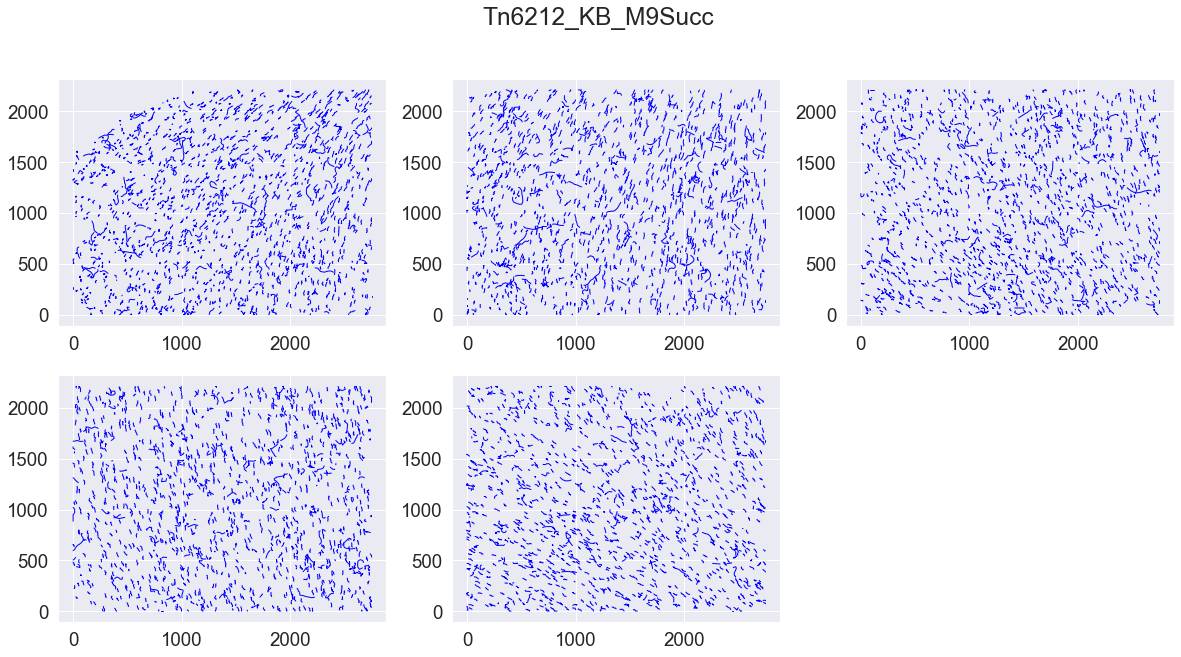

In [19]:
Data=pd.read_csv("../results/TrackMate_traj_Motility_27.10.2020.csv")
data_viz.plot_traj_overlay_replicas(Data,dxx)

For each experiment TrackMate detected more than 500 trajectories most of these trajectories are longer than 7 frames. See the graphs below.

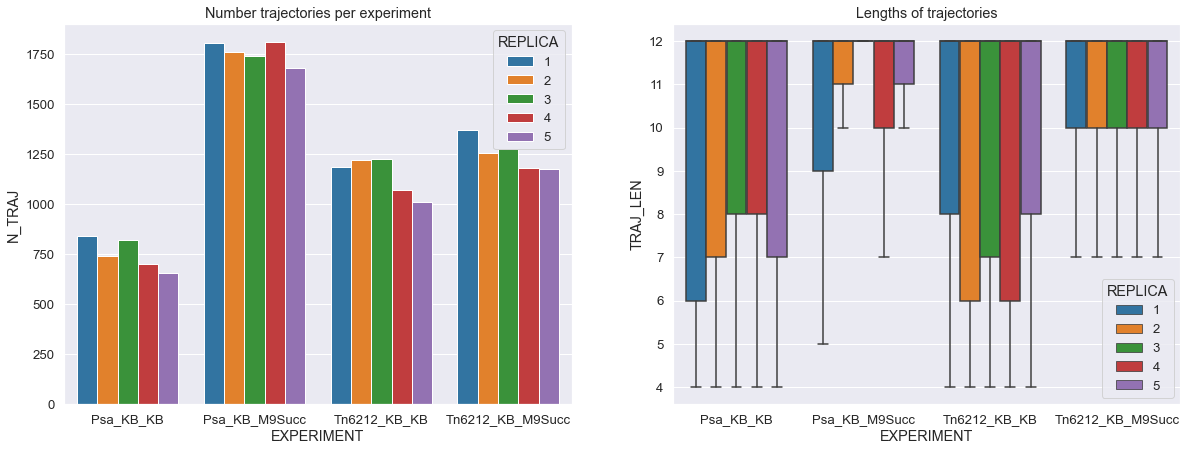

In [20]:
sns.set(font_scale=1.2)
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,7))
Stat_Traj_Number=Data.groupby(['EXPERIMENT','REPLICA']).apply(lambda X: np.size(np.unique(X["TRACK_ID"]))).reset_index(name='N_TRAJ')
sns.barplot(x="EXPERIMENT",y="N_TRAJ",hue="REPLICA",palette="tab10",data=Stat_Traj_Number,ax=ax[0])
ax[0].set_title("Number trajectories per experiment")


Stat_Traj_Length=Data.groupby(['EXPERIMENT','REPLICA',"TRACK_ID"]).apply(len).reset_index(name="TRAJ_LEN")
sns.boxplot(x="EXPERIMENT",y="TRAJ_LEN",hue="REPLICA",palette="tab10",showfliers = False,data=Stat_Traj_Length,ax=ax[1])
ax[1].set_title("Lengths of trajectories");

## Check flow in the chamber
The flow in the chamber could strongly affect bacterial trajectories, because the flow introduces preferred direction for bacteria displacement. Therefore, before trajectories analysis we checked and estimated flow.

To estimate flow in the chamber, we measured displacements (dx, dy) of each cell between every pair of consecutive frames. These displacements are presented below as scatter plots - separated by replicas. Each point represent a displacement of a single cell between two frames.

Then, we fitted the distribution of displacements with two-dimensional Gauss distribution, which allowed us to find the mean displacement in the experiment and variations of displacement among independent cell movements.
Without a flow (pure Brown motion), the mean displacement is zero.
The presence of flow manifests as a non-zero mean of displacements distribution.
On the figures below, the fitted Gaussian distribution is shown by the point color: bright yellow at the center of distribution, and darker towards the tails.

The absolute value of the mean displacement is characterized by the value $r>0$ - the distance between the center of fitted displacements distribution and the origin of coordinates.
We additionally compute flux coefficient -- the relative impact of the flow in comparison with cell diffusion, as $\text{flux} = \frac{r}{std}$, where $std$ is the leading eigenvalue of the covariance matrix (the maximal observed diffusion).
When $\text{flux} > 1$, then the flow plays larger role in the cell movement than the diffusion, otherwise, the diffusion has more impact.

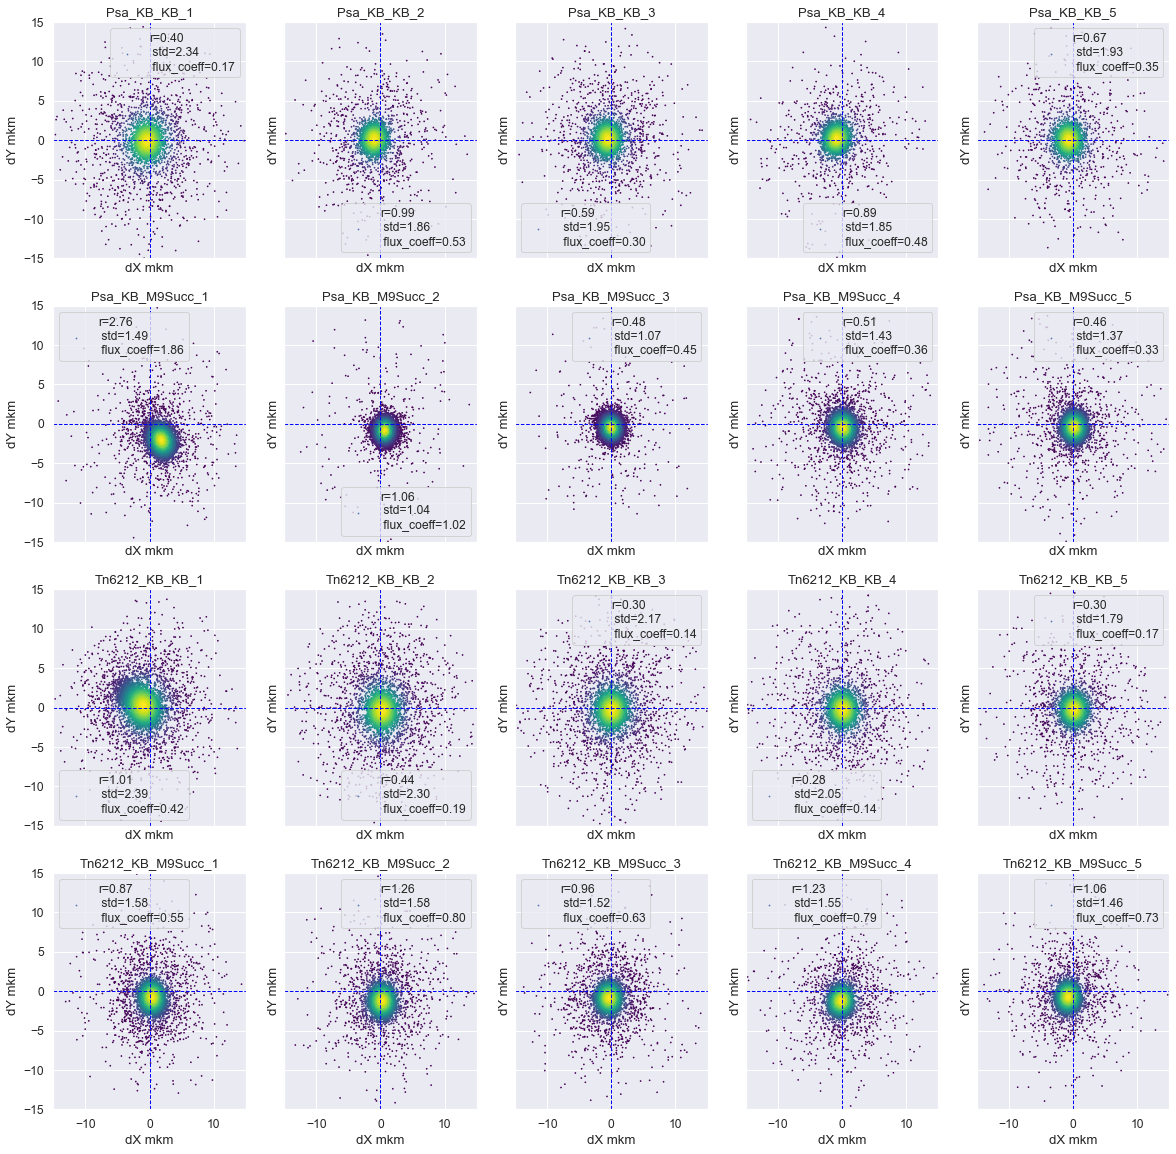

In [21]:
import traj_descriptors
import scipy

Displacement_data = pd.DataFrame()
for id, traj in Data.groupby(['TRACK_ID']):
    dr,mod=traj_descriptors.displacement(traj)
    disp=pd.DataFrame(dr,columns=['DX','DY'])
    disp['MOD_DR']=mod
    disp['EXPERIMENT']=traj['EXPERIMENT'].values[0]
    disp['REPLICA']=traj['REPLICA'].values[0]
    disp['TRACK_ID']=traj['TRACK_ID'].values[0]
    Displacement_data=pd.concat([Displacement_data,disp])
    
def estimate_flux(group):
    """ 
    Estimate flux
    """
    Mean=np.mean(group,axis=0)
    r_mean=np.sqrt(Mean['DX']**2+Mean['DY']**2)
    covariation_matrix=np.cov(group['DX'],group['DY'])
    eigen_values, eVa = np.linalg.eig(covariation_matrix)
    maxLambda=np.max(eigen_values)
    flux_coefficient=r_mean/np.sqrt(maxLambda)
    return r_mean,np.sqrt(maxLambda),flux_coefficient

def Gaussian2D_pdf(group):
    """
    calculates probability spread function  for each point of the replica data
    using 2D Gauss distribution
    2D gauss distribution estimated from the replica data
    
    input: replica displacement data
    output: pdf for each value in displacement data
    """
    Mean=group.mean(axis=0)
    rv=scipy.stats.multivariate_normal(mean=[Mean['DX'],Mean['DY']], cov=np.cov(group['DX'],group['DY']))
    pdf_data=[rv.pdf([group['DX'].iloc[i],group['DY'].iloc[i]]) for i in range(group.shape[0])]
    return pdf_data



sns.set(font_scale=1.1)
fig,ax=plt.subplots(nrows=4,ncols=5,figsize=(20,20),sharex=True,sharey=True)
axx=ax.ravel()
counter=0
quantile=0.01

#plot each replica in separate graph
Flux_coefficients=[]
for experiment_id, exp_group in Displacement_data.groupby(["EXPERIMENT"]):
     for replica_id, replica_group in exp_group.groupby("REPLICA"):
            rmean,vmaxLambda,flux_coefficient=estimate_flux(replica_group)
            Flux_coefficients.append({"experiment":experiment_id,
                                      "replica_id":replica_id,
                                      "r_mean":rmean,
                                      "std":vmaxLambda,
                                      "flux_coeff":flux_coefficient})
            pdf=Gaussian2D_pdf(replica_group)
            for_label='r={:.2f}\n std={:.2f}\n flux_coeff={:.2f}'.format(rmean,vmaxLambda,flux_coefficient)
            
            #figure
            axx[counter].set_title(experiment_id+"_"+str(replica_id))
            axx[counter].scatter(replica_group.DX,replica_group.DY,s=0.5,c=pdf,cmap='viridis',label=for_label)
            #axx[counter].scatter(replica_group['DX'].iloc[outliers],replica_group['DY'].iloc[outliers],c='red',marker='x',s=0.5)
            axx[counter].axvline(x=0,color='blue',linestyle='dashed',linewidth=1)
            axx[counter].axhline(y=0,color='blue',linestyle='dashed',linewidth=1)
            axx[counter].set_xlim(-15,15)
            axx[counter].set_ylim(-15,15)
            axx[counter].set_xlabel("dX mkm")
            axx[counter].set_ylabel("dY mkm")
            axx[counter].legend()
            counter=counter+1


#fig.savefig("../results/test/"+"StepDisplacement.png",dpi=500,bbox_inches='tight')

Flux=pd.DataFrame(Flux_coefficients)

Barplots of flux coefficients are presented on the figure below. The highest flux coefficients (larger 1.0) were detected for 1 and 2 replicas of PSA_KB_M9Succ. So, we excluded these replicas from further analysis because of strong flow in the chamber.

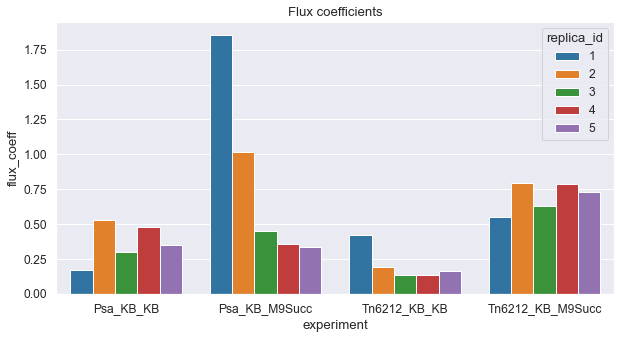

In [6]:
sns.set(font_scale=1.1)
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(10,5))
g=sns.barplot(x='experiment',y='flux_coeff',hue="replica_id",palette="tab10",data=Flux,ax=ax)
plt.title("Flux coefficients")
fig.savefig("../results/test/"+"FluxCoefficient.png",dpi=500,bbox_inches='tight')

In [7]:
# exclude replicas
Data=Data[((Data['EXPERIMENT']=="Psa_KB_M9Succ") & (Data["REPLICA"]==1))==False]
Data=Data[((Data['EXPERIMENT']=="Psa_KB_M9Succ") & (Data["REPLICA"]==2))==False]

Data.to_csv("../results/TrackMate_traj_Motility_27.10.2020_cleaned_flux.csv")

## Trajectories descriptors and measurements
To analyze trajectories we calculated set of the measurements for each trajectory.Some descriptors illustrated  on the figure below. 


### trajectory local measurements 
Measurements that map trajectory to a list of numbers
* **Displacements**(dx, dy) between every pair of consecutive frames in trajectory.
* **Global Angles** Global angle is a angle between movement direction with respect to the X-axis of fixed coordinate system (theta on the figure below)
* **Relative Turning Angles** Relative Angle is a turning angle that describes how much bacteria movement deviates from previous direction. (alpha on the figure below).
 

### trajectory global descriptors
Measurements that characterize trajectory as a whole (mapping trajectory to one number)
* **Total displacement** is a total traveled path,in other words, sum of the displacements.
* **End to End distance** is a distance between the start and end of trajectory.
* **Max Distance** maximum distance traveled from the trajectory origin
* **Length of trajectory**  number of time frames for trajectory
* **Persistence** is a ratio End to End distance to Total displacement. For directed motion persistent is close to 1.0 
* **MSD** is a mean squared displacement 


<img src="../results/illustration.jpg" width="359" height="204">



### Relative Turning angle distribution
The relative turning angle desribes how much bacteria movement deviates from previous directions. 
The distributions of relative turning angles are presented for different experiments and replicas on the figure below, . We could clearly see that all distribution skewed towards acute angles. So, the bacteria prefer to persist  movement directions rather than turn.

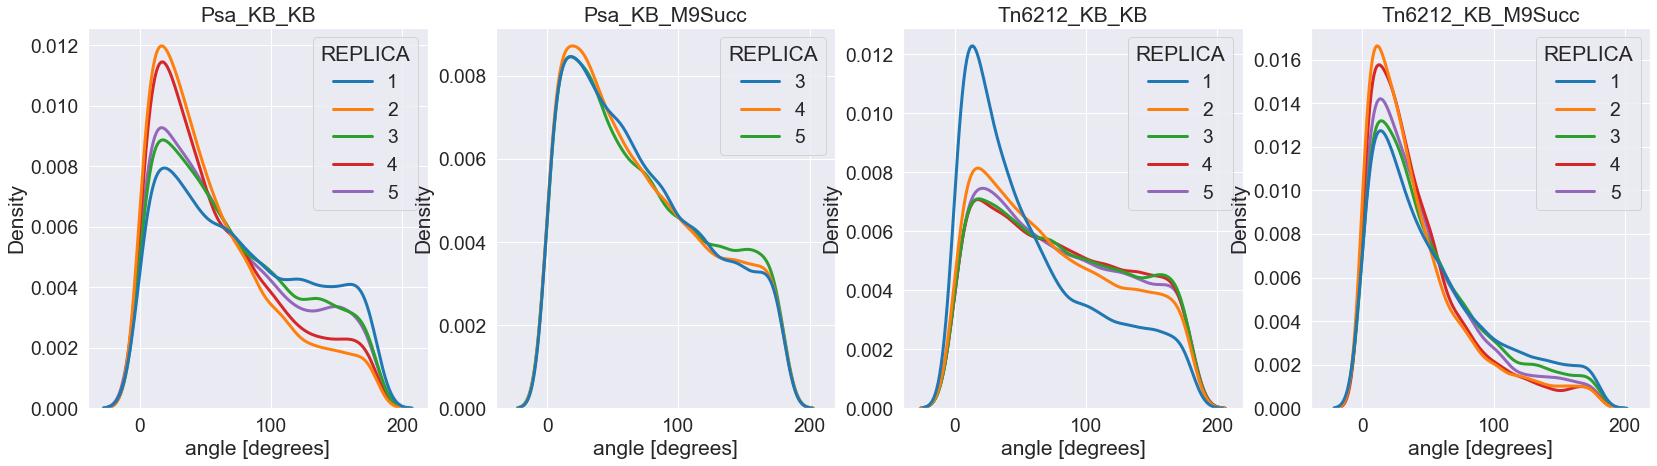

In [7]:
RelativeAngle_data=pd.read_csv("../results/Relative_Angle.csv")
sns.set(font_scale=1.75)
fig,ax=plt.subplots(nrows=1,ncols=4,figsize=(28,7),sharex=True)

counter_exp=0
for exp_id, experiment in RelativeAngle_data.groupby("EXPERIMENT"):
    sns.kdeplot(data=experiment,x="REL_ANGLE",hue="REPLICA",ax=ax[counter_exp],palette="tab10",common_norm=False,linewidth=3)
    ax[counter_exp].set_title(exp_id)
    ax[counter_exp].set_xlabel("angle [degrees]")
    counter_exp=counter_exp+1

Relative turning angle distribution for experiments (replicas combined) presented below. We can see here that Tn6212_KB_M9Succ differs from other experiment.Tn6212_KB_M9Succ angles distribution skewed to the acute angles more than other experiments. This might indicate that Tn6212_KB_M9Succ rarerly change movement directions than other experiments, also it might indicate flow in the chamber. 

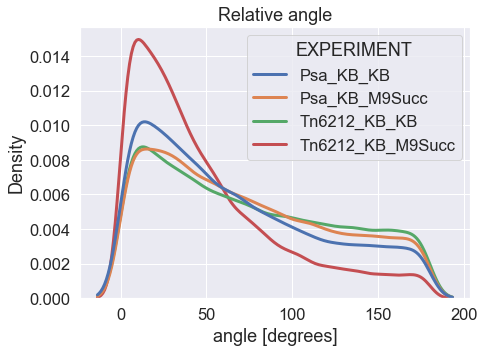

In [9]:
sns.set(font_scale=1.5)
plt.figure(figsize=(7,5))
sns.kdeplot(data=RelativeAngle_data,x="REL_ANGLE",hue="EXPERIMENT",common_norm=False,common_grid=True,lw=3)
plt.xlabel("angle [degrees]")
plt.title("Relative angle");

#### Global angle distribution
The global turning angle defined as a angle between movement directions with respect to the X-axis of fixed coordinate system. The global turning angle gives information about the global movement direction.


On the figure below, the distributions of global turning angles are presented for different experiments and replicas. We could clearly see that all distribution are skewed and bacteria movements have preferred directions respect to the X-axis. In contrast, global angles for artificially generated Brownian trajectories follow uniform distribution. Preferred directions indicate flow in the chamber. 

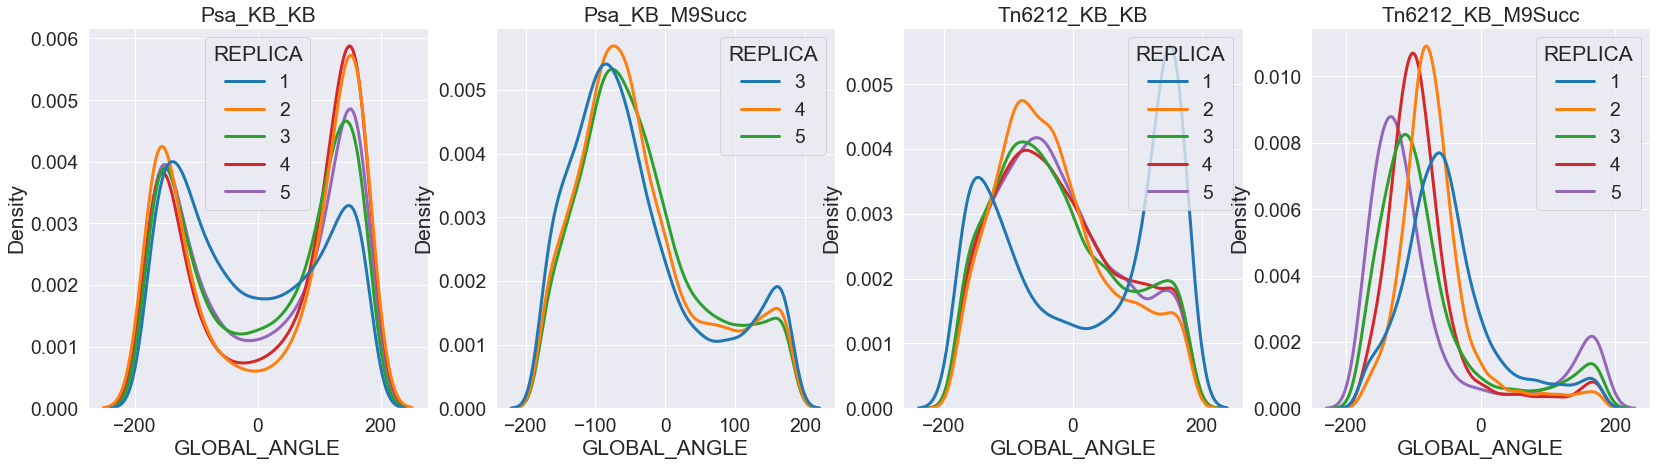

In [3]:
GlobalAngle_data=pd.read_csv("../results/Global_Angle.csv")
sns.set(font_scale=1.75)
fig,ax=plt.subplots(nrows=1,ncols=4,figsize=(28,7))

counter_exp=0


for exp_id, experiment in GlobalAngle_data.groupby("EXPERIMENT"):
    sns.kdeplot(data=experiment,x="GLOBAL_ANGLE",hue="REPLICA",ax=ax[counter_exp],palette="tab10",common_norm=False,linewidth=3)
    ax[counter_exp].set_title(exp_id)
    ax[counter_exp].set_xlabel("GLOBAL_ANGLE [degrees]")
    counter_exp=counter_exp+1
    

Global turning angle distribution for experiments (replicas combined) is presented below. 

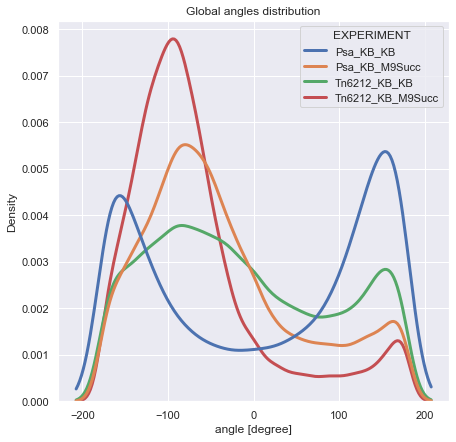

In [15]:
sns.set(font_scale=1)
plt.figure(figsize=(7,7))
plt.title("Global angles distribution")
plt.xlabel("angle [degree]")
sns.kdeplot(data=GlobalAngle_data,x="GLOBAL_ANGLE",hue="EXPERIMENT",common_norm=False,common_grid=True,linewidth=3);

## PCA and Gaussian Mixture clustering

To classify the set of trajectories, we characterized each trajectory by six descriptors: total displacement, end-to-end distance, maximum distance from origin, MSD, median speed, and median relative angle (see section 1.4 for details).
As a result, each trajectory was represented by a set of six parameters.

To get a intuitive understanding of the dataset, we reduced its dimensionality.
To do so, for each experiment, we performed PCA. 
Keeping the first three principal components explains about 95% of overall data variance (see the first and second columns in Figure below).
Therefore a reduction from six dimensions down to three preserves most of the information from the dataset.

Looking at the obtained three dimensional distributions, we found that the dataset appears to be composed of two subsets: a dense compact cluster and a diffuse halo. 
On the third column of the figure below, we present a two-dimensional map (first two principal components), where this structure is also visible.

To support our observations, we fitted a Gaussian mixture model with two clusters.
This model assumes that the present data is generated by two Gaussian distributions, and fit their parameters (mean and covariance).
The result of the fitting is presented on the fourth column of the figure below.
There the same data points are colored according to two fitted clusters.
The results of the fitting support our initial interpretation: the first (purple "compact") cluster features relatively low covariance, while the second (orange "diffuse") cluster has much larger variation in trajectories characteristics.

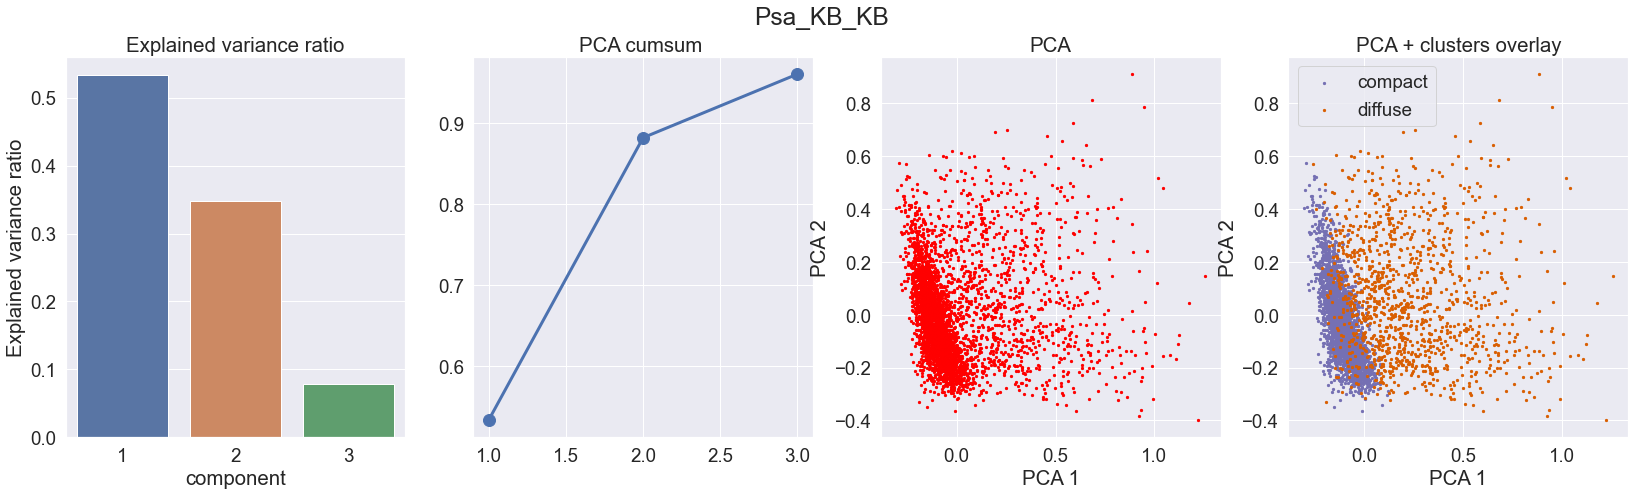

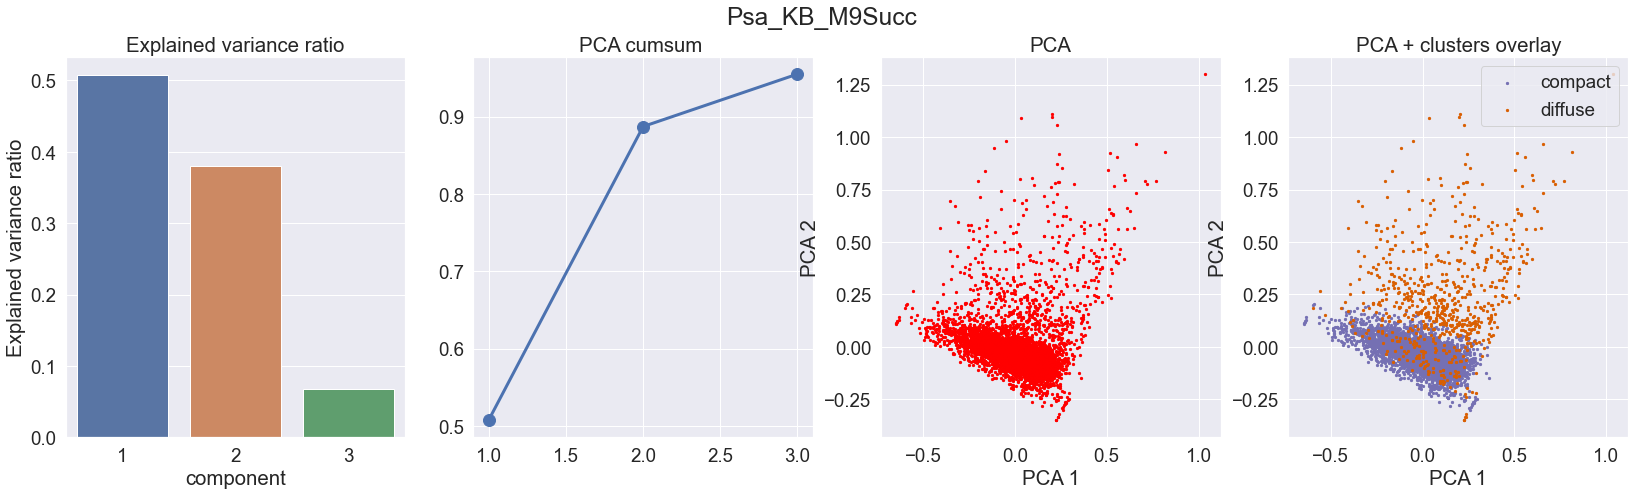

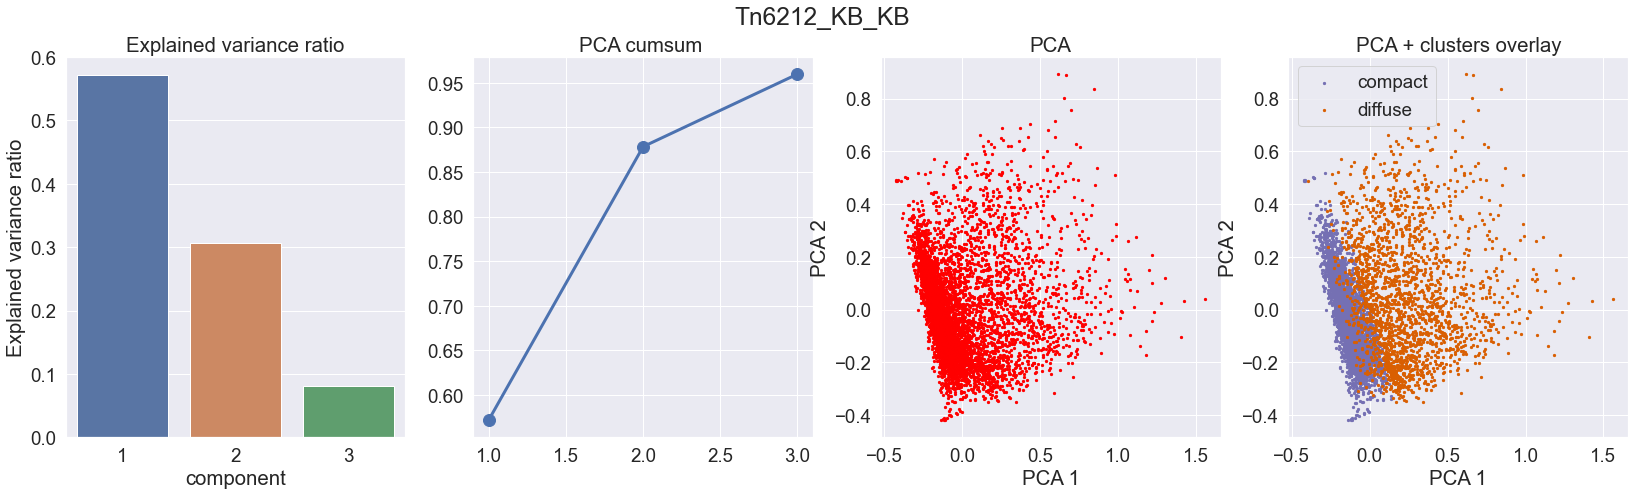

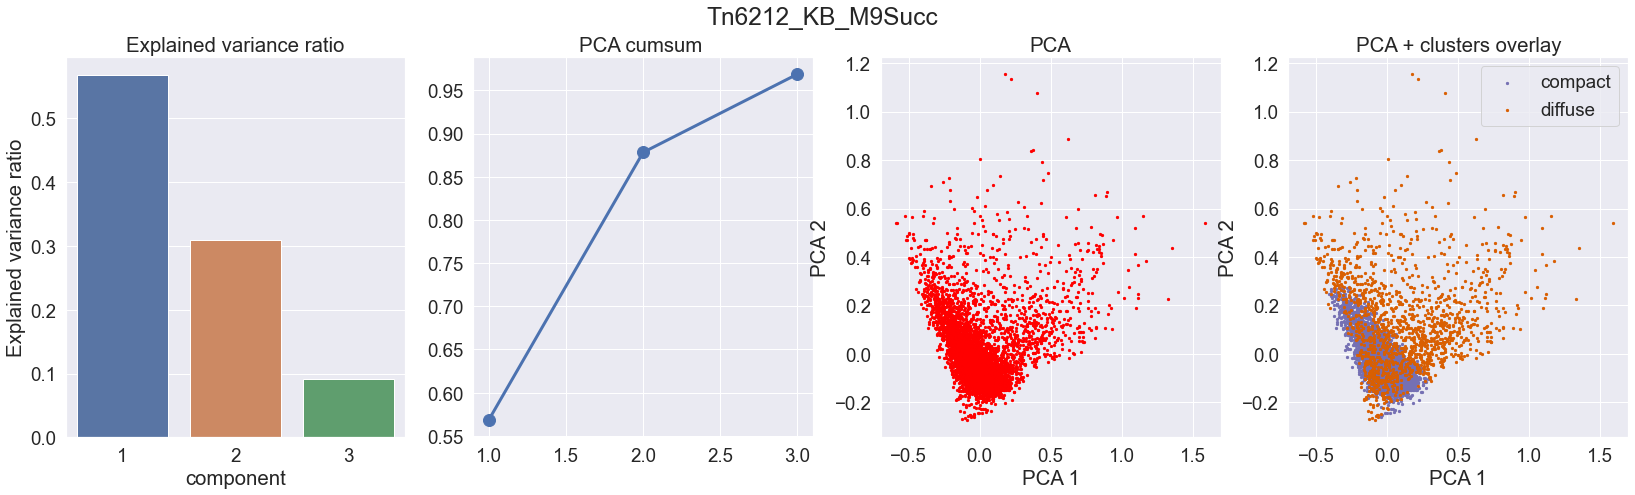

In [6]:
TrajDescriptors=pd.read_csv("../results/Track_Mate_traj_descriptors_27.10.2020_cleaned_flux.csv")
TrajDescriptors.dropna(inplace=True)


feature_names=['TOTAL_DIST', 'END_TO_END','MAX_DIST_ORIG','MSD', 'MED_SPEED','MED_REL_ANGLE']

MarkedCluster=pd.DataFrame()
ListExperiment=TrajDescriptors['EXPERIMENT'].unique()

for experiment in ListExperiment:
    Test_descriptors_replica=TrajDescriptors.groupby(['EXPERIMENT']).get_group((experiment)).reset_index()
    X=Test_descriptors_replica[feature_names]

    # scaling
    scaler=MinMaxScaler()
    Xscaled=scaler.fit_transform(X)

    # PCA
    pca=PCA(n_components=3)
    X3d=pca.fit(Xscaled).transform(Xscaled)
    #print(pca.explained_variance_ratio_)
    #print(np.cumsum(pca.explained_variance_ratio_))

    #Clustering
    gm=GaussianMixture(n_components=2,n_init=10)
    gm.fit(X3d)
    cluster=gm.predict(X3d)
    Test_descriptors_replica["CLUSTER"]=cluster
    
    
    # determine diffuse cluster
    diffuse=cluster[np.argmax(X3d[:,1])]
    if diffuse==0:
        cluster=1-cluster
    
    # marked list
    Test_descriptors_replica["CLUSTER_TYPE"]=cluster
    MarkedCluster=pd.concat([MarkedCluster,Test_descriptors_replica])

    # Viz
    sns.set(font_scale=1.7)
    fig,ax=plt.subplots(nrows=1,ncols=4,figsize=(28,7))
    variance_component=pd.DataFrame({"component":range(1,4),"Explained variance ratio":pca.explained_variance_ratio_})
    sns.barplot(data=variance_component,x="component",y="Explained variance ratio",ax=ax[0])
    ax[0].set_title("Explained variance ratio")
    
    ax[1].plot(range(1,4),np.cumsum(pca.explained_variance_ratio_),lw=3,marker='o',markersize=12)
    ax[1].set_title("PCA cumsum ")
    ax[2].set_xlabel("component")
    ax[2].set_ylabel("PCA cumsum")

    ax[2].scatter(X3d[:,0].astype(float), X3d[:,1].astype(float),s=5,color='red')
    ax[2].set_title("PCA")
    ax[2].set_xlabel("PCA 1")
    ax[2].set_ylabel("PCA 2")
    
    ax[3].scatter(X3d[(cluster==0),0].astype(float), X3d[(cluster==0),1].astype(float),s=5,color="#7570b3",alpha=1,label="compact")
    ax[3].scatter(X3d[(cluster==1),0].astype(float), X3d[(cluster==1),1].astype(float),s=5,color="#d95f02",alpha=1,label="diffuse")
    ax[3].set_title("PCA + clusters overlay")
    ax[3].set_xlabel("PCA 1")
    ax[3].set_ylabel("PCA 2")
    ax[3].legend()

    plt.suptitle(experiment)
    
MarkedCluster.to_csv("../results/Trajectory_Descriptors_Marked_clusters.csv")

### Cluster analysis

The sizes of compact and diffuse clusters are not of equal.
In all experiments, the fraction of trajectories belong to the compact cluster was between 60% and 90%, while the diffuse cluster was responsible only for 10% - 40% of trajectories.

In [8]:
TrajMarkedDescriptors=pd.read_csv("../results/Trajectory_Descriptors_Marked_clusters.csv")

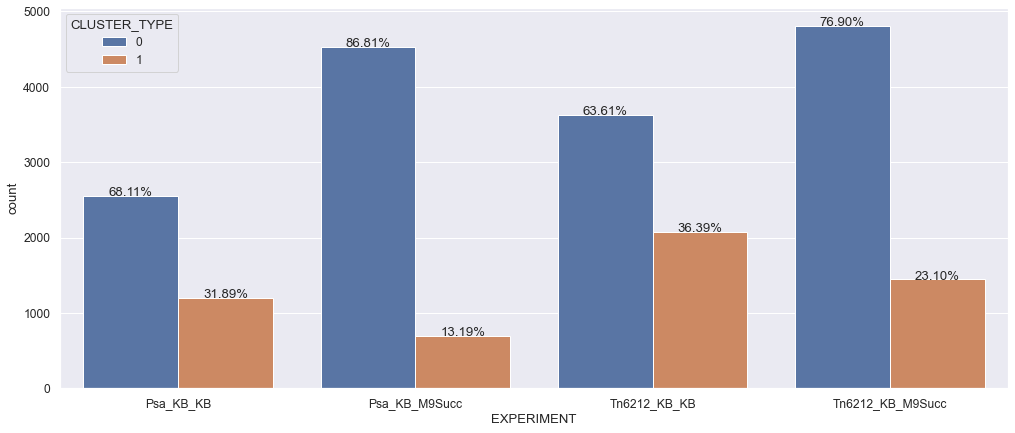

In [23]:
fig,ax=plt.subplots(figsize=(17,7))
ax = sns.countplot(x="EXPERIMENT", hue='CLUSTER_TYPE', data=TrajMarkedDescriptors) # for Seaborn version 0.7 and more

total = TrajMarkedDescriptors.groupby("EXPERIMENT").count().values[:,0]
counter=0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total[counter]*100),
            ha="center") 
    counter=counter+1
    
    if counter>3:
        counter=0

Next, we were looking for what makes these clusters different in terms of descriptors.
The two most clear differences were found in the median speed and the median relative angle, see the figure below.
There, the blue histogram shows the compact cluster and the red histogram shows the diffuse cluster.
The gray histogram demonstrates the combined distribution of the descriptor values.
Trajectories from the compact cluster, demonstrate typically low speed with a little variance.
At the same time, the trajectories from the diffuse cluster typically have a larger speed with much greater variance.
The distributions of the median relative angle are both unimodal for each cluster but the most common turning angle in the compact cluster is about 50 degrees, while for the diffuse cluster it is around 30 degrees.
Altogether, the compact cluster is composed of relatively slow cells which makes larger turns, while in the diffuse cluster, cells move faster and take less turns.

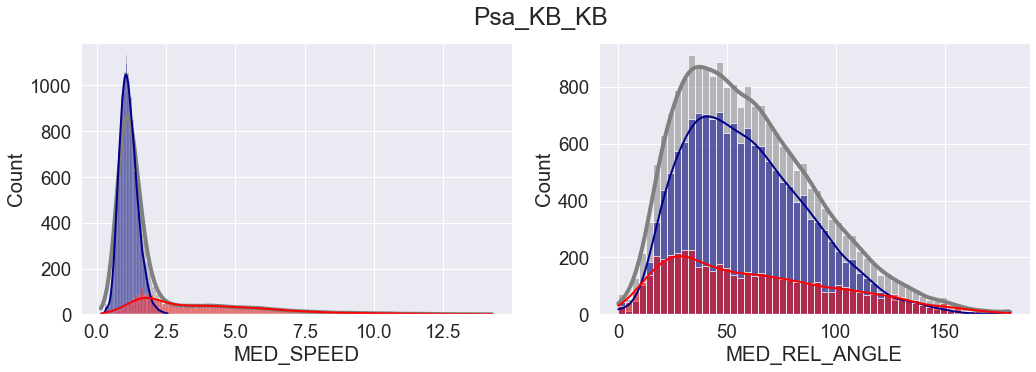

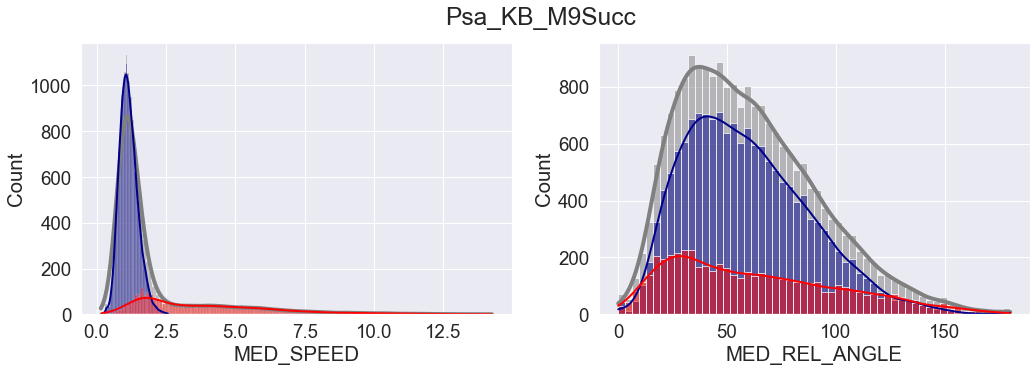

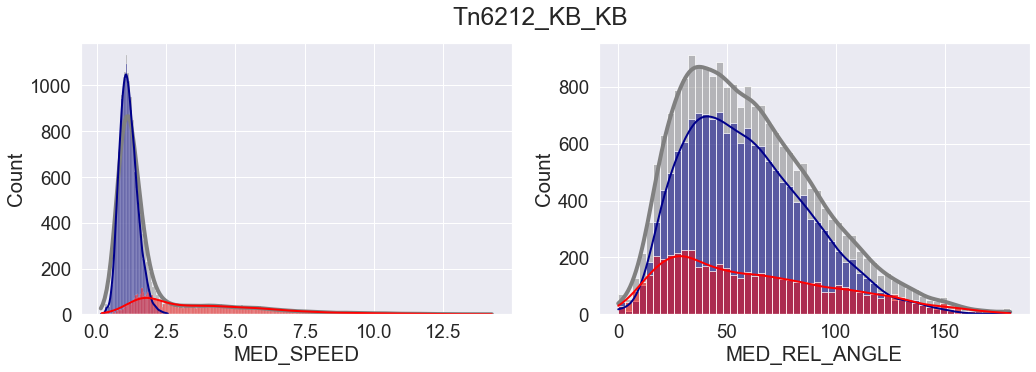

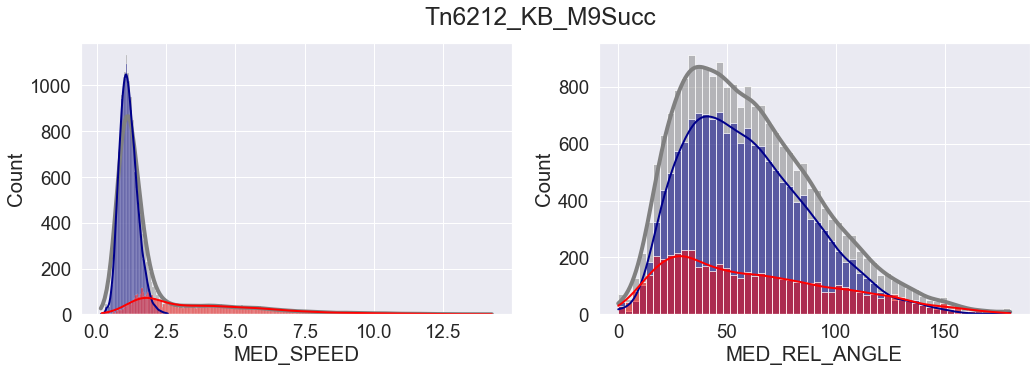

In [24]:
feature_names=['MED_SPEED','MED_REL_ANGLE',"CLUSTER_TYPE"]
sns.set(font_scale=1.7)

for exp_id,exp in TrajMarkedDescriptors.groupby(['EXPERIMENT']):
    counter=0
    
    fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(17,5))
    plt.suptitle(exp_id)
    
    for feature in feature_names[:-1]:
        class1=TrajMarkedDescriptors[TrajMarkedDescriptors["CLUSTER_TYPE"]==0]
        class2=TrajMarkedDescriptors[TrajMarkedDescriptors["CLUSTER_TYPE"]==1]
        
        axx=sns.histplot(TrajMarkedDescriptors[feature],kde=True,color = 'gray',line_kws=dict(linewidth=4),ax=ax[counter])
        width=axx.patches[0].get_width()
        sns.histplot(class1[feature],binwidth=width,kde=True,color = 'darkblue',
                     line_kws=dict(linewidth=2),fill=True,ax=ax[counter])
        sns.histplot(class2[feature],binwidth=width,kde=True,color = 'red',
                     line_kws=dict(linewidth=2),ax=ax[counter])
    
        #sns.histplot(class1[feature],kde=True,color = 'darkblue',kde_kws={'linewidth': 4},ax=ax[counter])
        counter=counter+1;

Additionally, we found that diffuse trajectories have less time steps than compact ones.
The figure below shows the boxplot of the trajectory length for each cluster.
In the compact cluster, the vast majority of trajectories have the maximal possible length of 12 segments (and the box is effectively invisible).
Only a few shorter compact trajectories are present.
By contrast, the median segment count of the diffuse trajectories is only 6-7 steps.
This effect can be caused by the fast and directed movement of the cells from the diffuse cluster - within the period of record, these cells can come and leave the focal plane, so their trajectories cannot be recorded in the full length.

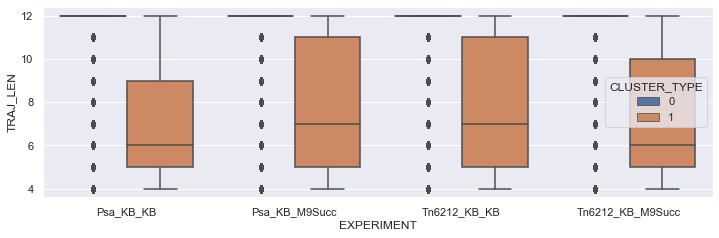

In [25]:
sns.set(font_scale=1)
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(12,3.5))

feature='TRAJ_LEN'
sns.boxplot(data=TrajMarkedDescriptors,y=feature,x="EXPERIMENT",hue="CLUSTER_TYPE",ax=ax)
sns.set(font_scale=1.7)

### Sample trajectories

Finally, we present the samples of 25 trajectories from each of the clusters.
These trajectories support our observations above: in compact cluster steps are shorter and large turning angles are more common than in the diffuse cluster.

#### Class 1 (compact)

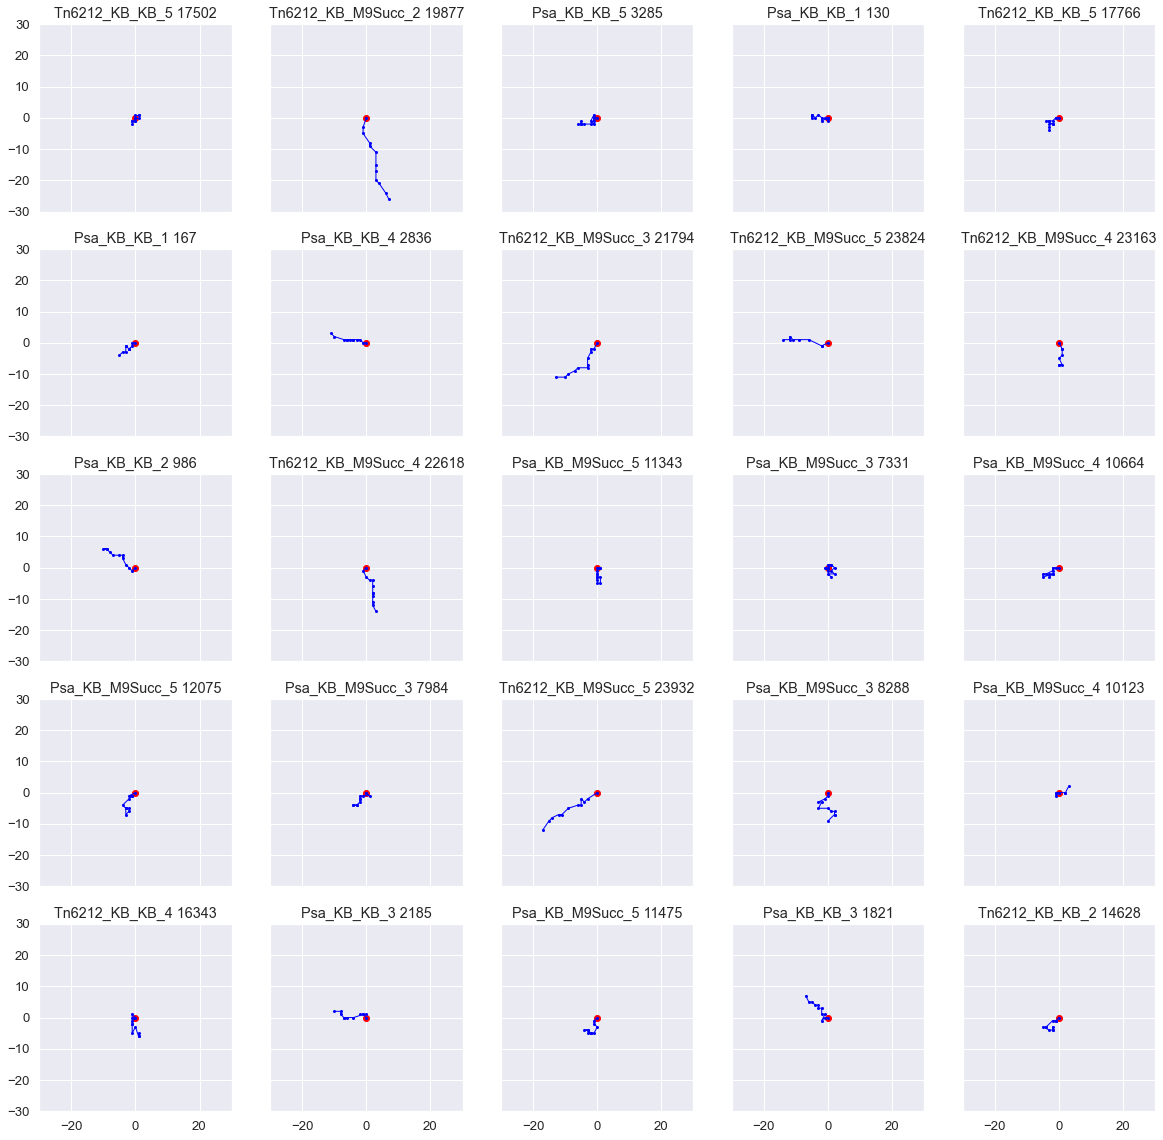

In [26]:
Coordinats=pd.read_csv("../results/TrackMate_traj_Motility_27.10.2020_cleaned_flux.csv")

class1=TrajMarkedDescriptors[TrajMarkedDescriptors["CLUSTER_TYPE"]==0]
class1_coordinats=Coordinats[Coordinats['TRACK_ID'].isin(class1['TRACK_ID'].values)]

data_viz.plot_sample_trajectories(class1_coordinats,1,5,3)

#### Class 2 (diffuse)

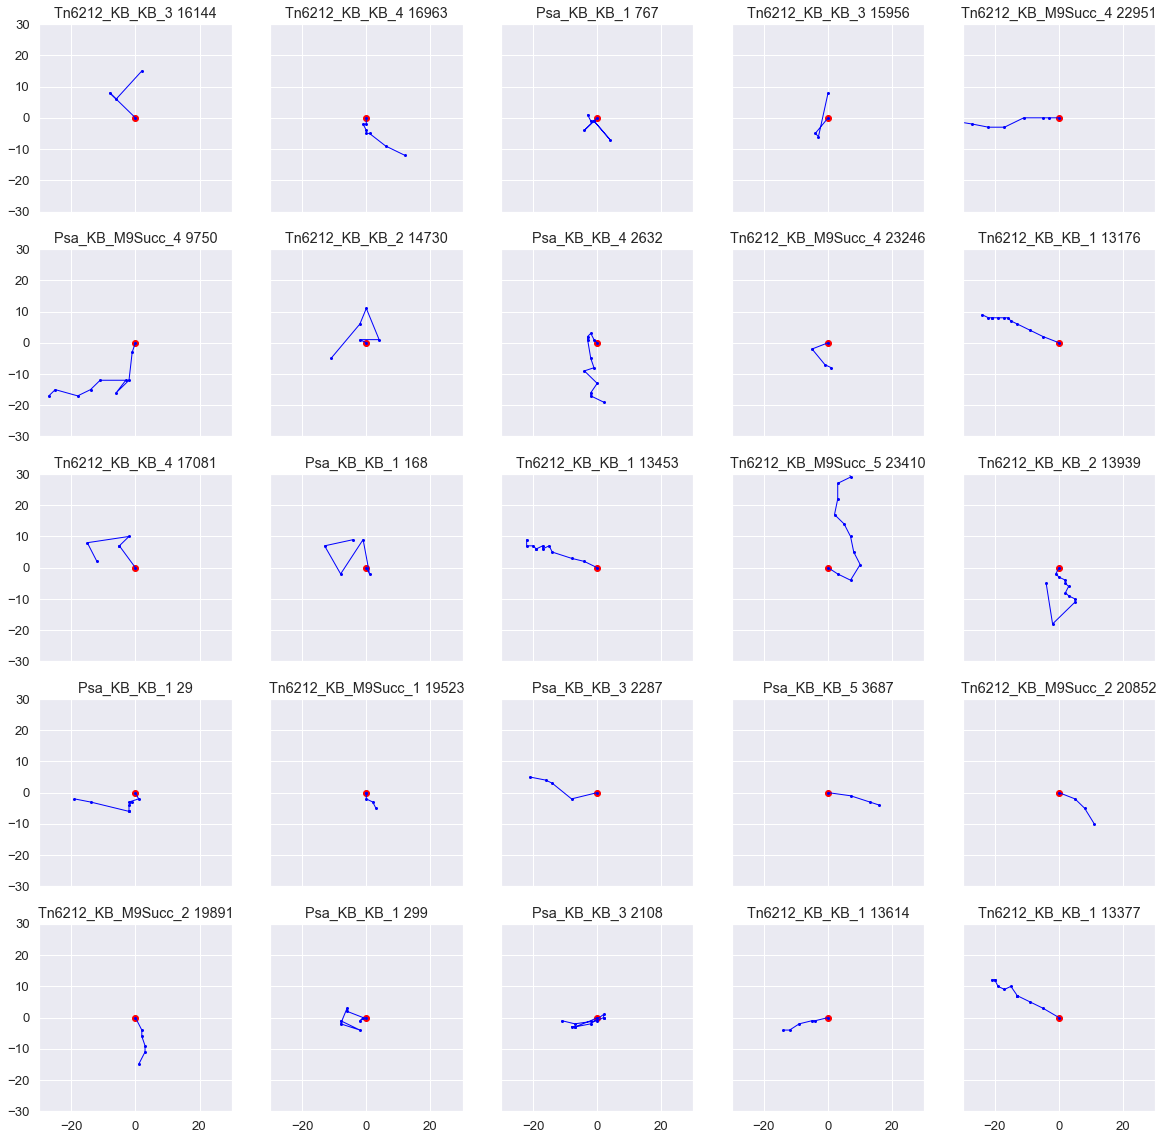

In [27]:
class2=TrajMarkedDescriptors[TrajMarkedDescriptors["CLUSTER_TYPE"]==1]
class2_coordinats=Coordinats[Coordinats['TRACK_ID'].isin(class2['TRACK_ID'].values)]
data_viz.plot_sample_trajectories(class2_coordinats,1,5,3)

### Trajectories overlay 
The overlay of all detected trajectories are presented below
#### The overlay class 1 (compact)

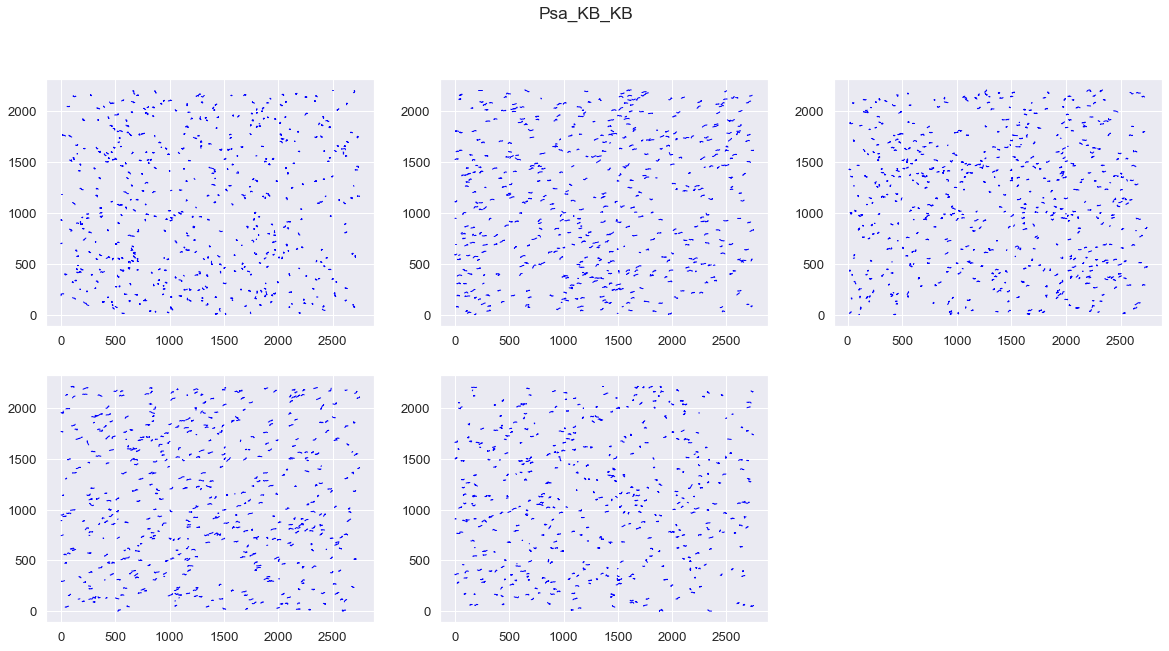

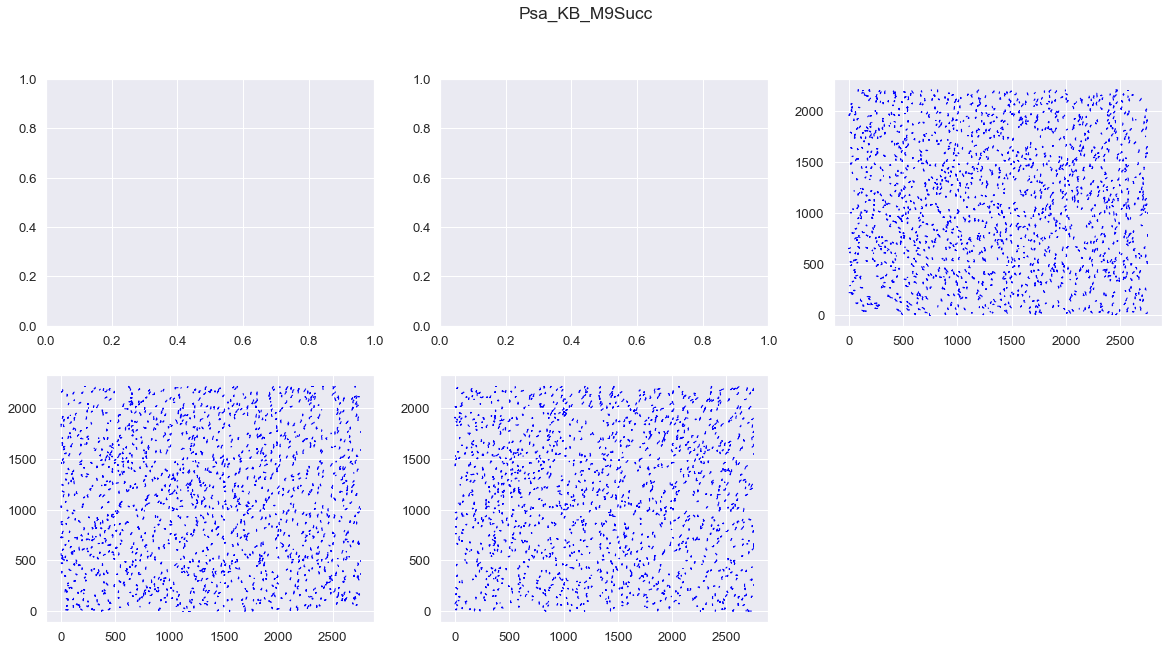

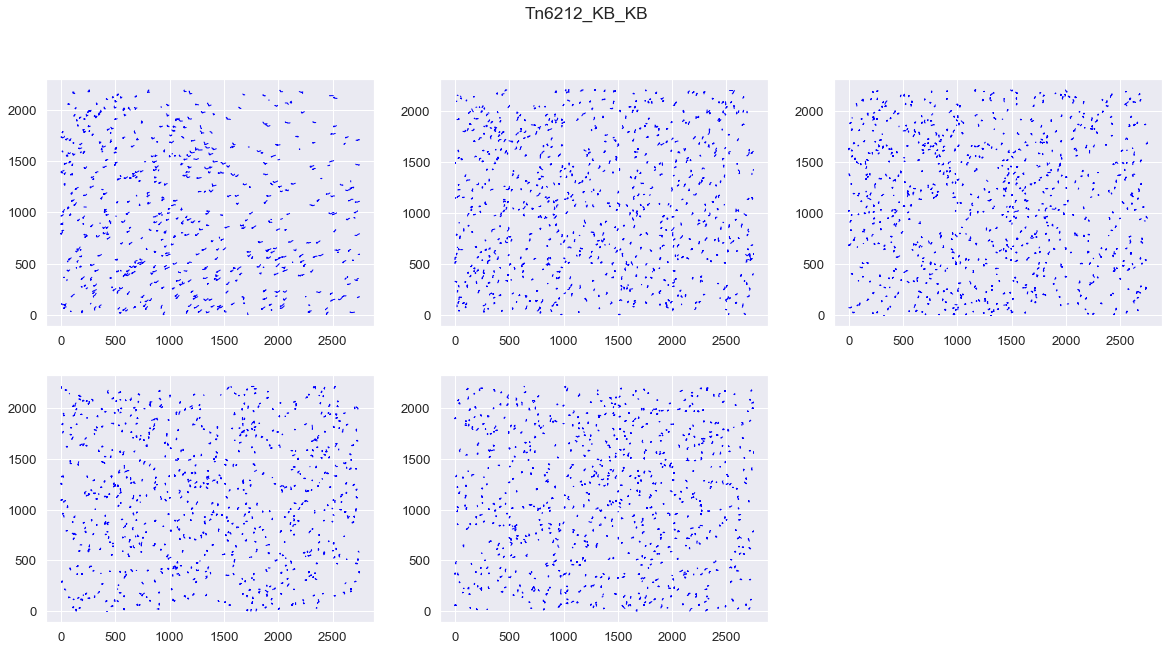

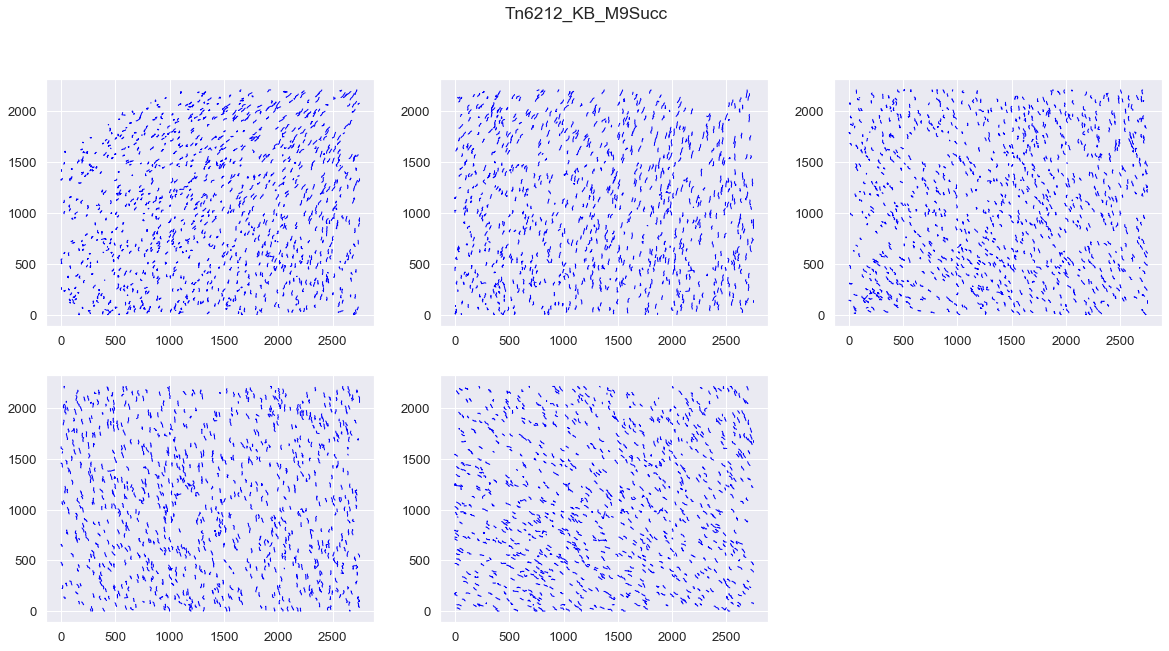

In [32]:
data_viz.plot_traj_overlay_replicas(class1_coordinats,dxx)

#### The overlay class 2 (diffuse)
The overlay of all detected trajectories are presented below

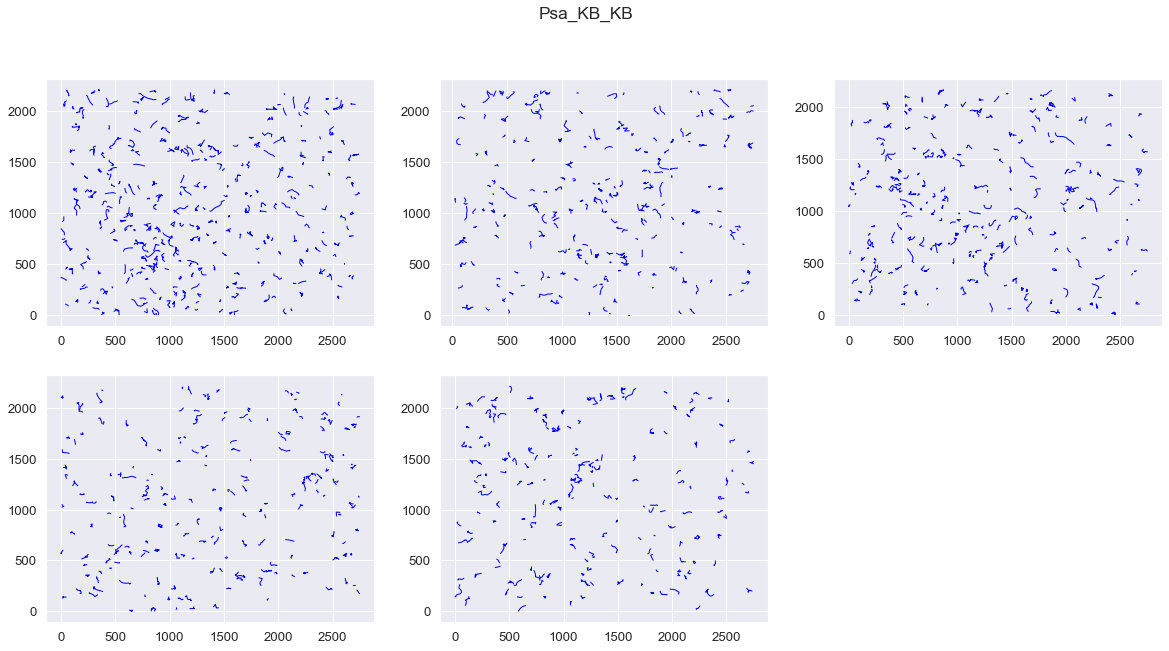

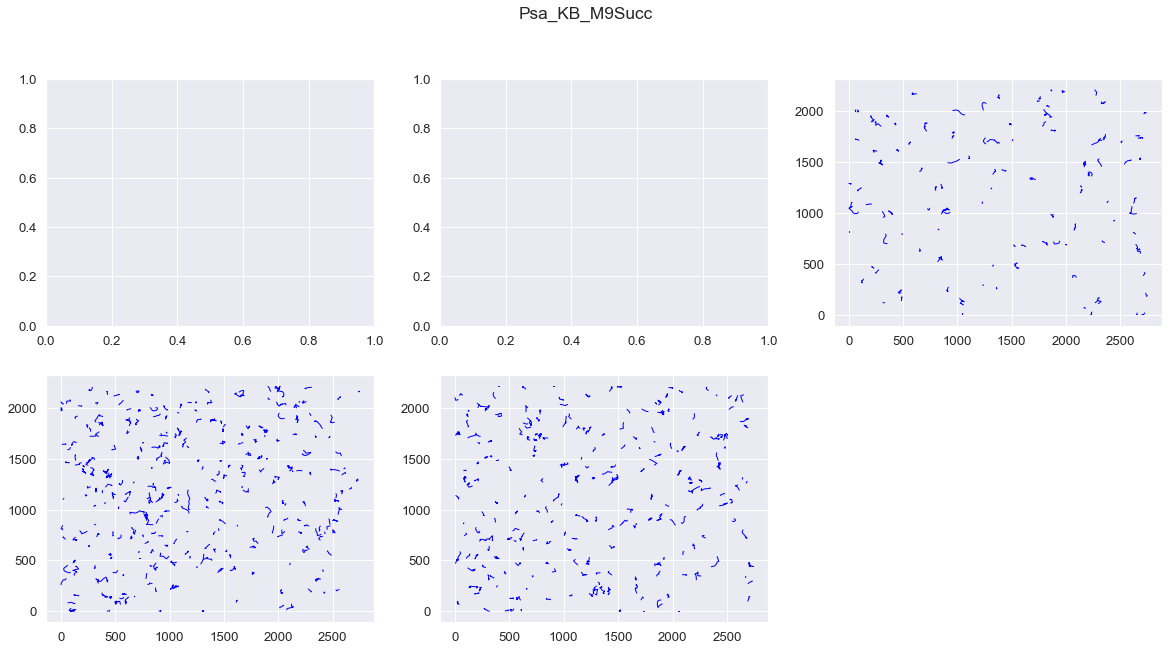

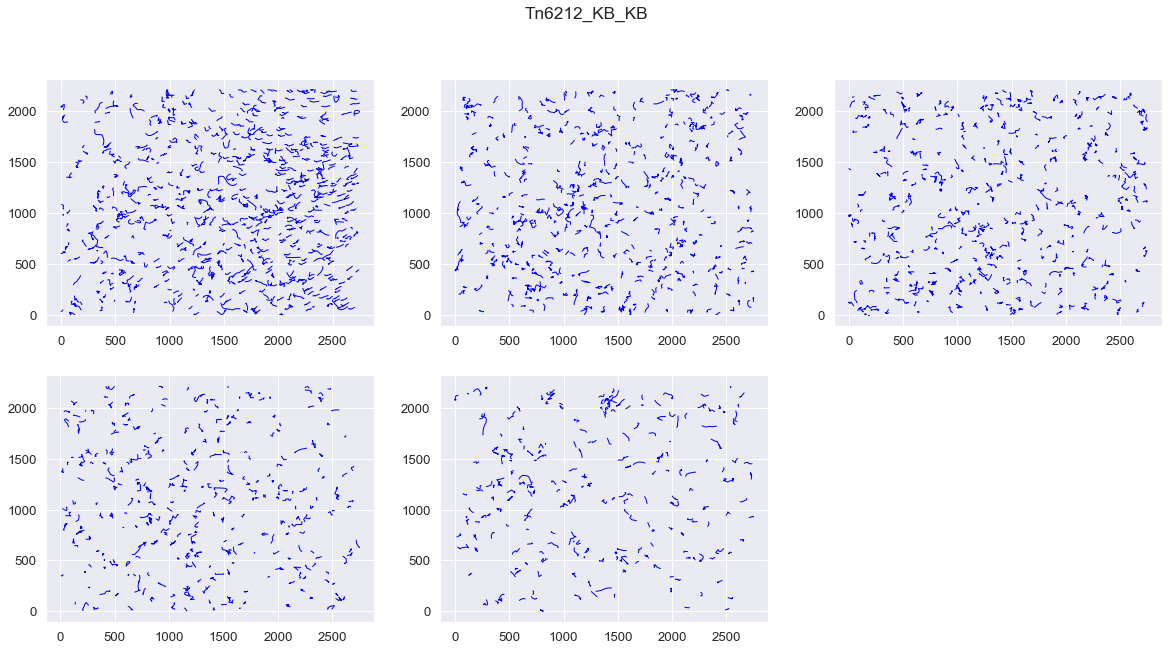

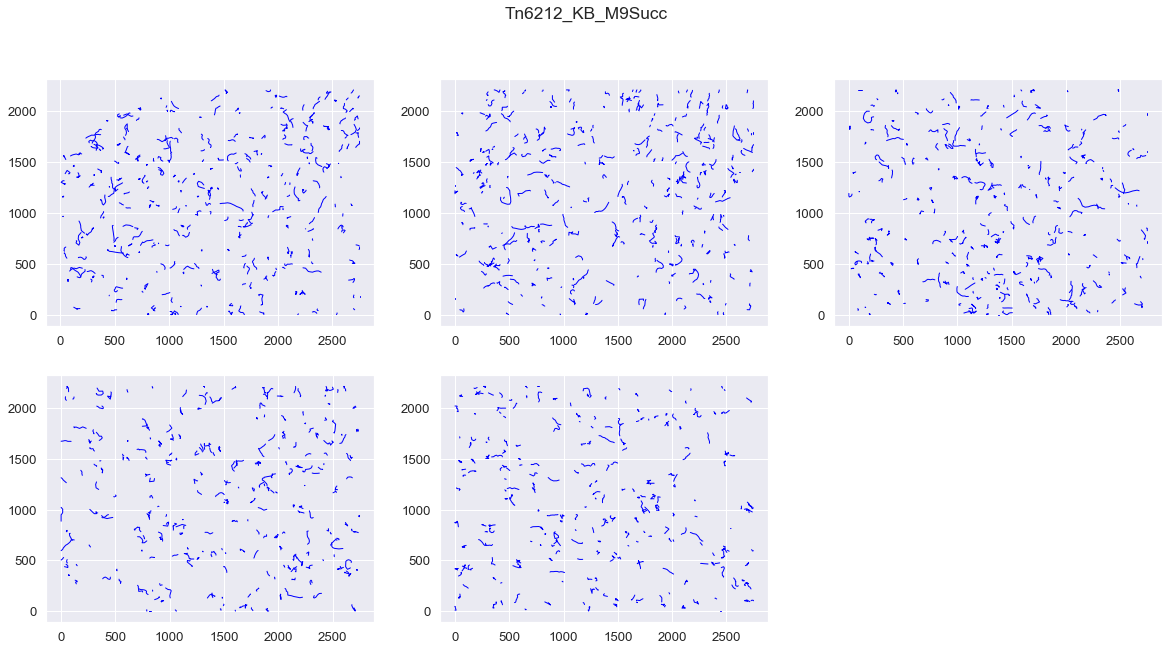

In [33]:
data_viz.plot_traj_overlay_replicas(class2_coordinats,dxx)